0
Upper Outer Coil force =  -6.016405758245734e-08 Lower Outer Coil force =  -1.820644984272229e-06 Magnet force =  -1.820644984272229e-06
1
Upper Outer Coil force =  1.63553378347001e-08 Lower Outer Coil force =  -1.395006101302785e-06 Magnet force =  -1.395006101302785e-06
[0. 1.]
[-6.01640576e-08  1.63553378e-08]
[-1.82064498e-06 -1.39500610e-06]
[-1.82064498e-06 -1.39500610e-06]


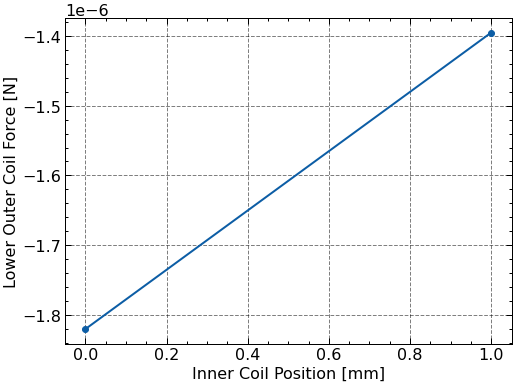

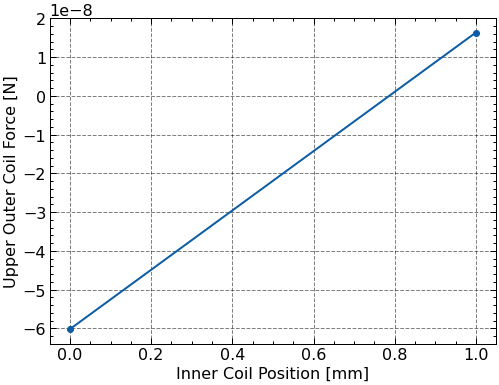

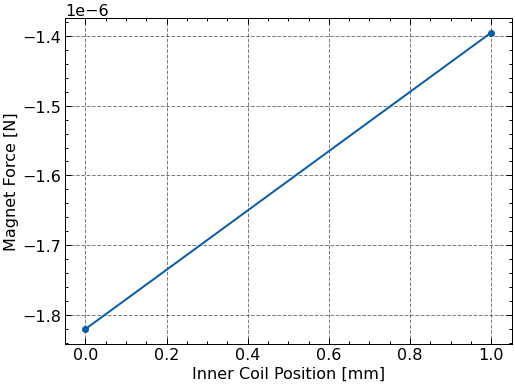

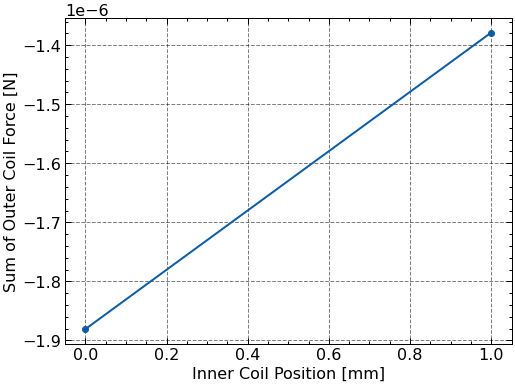

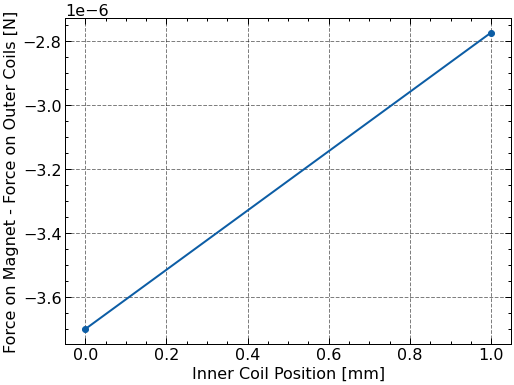

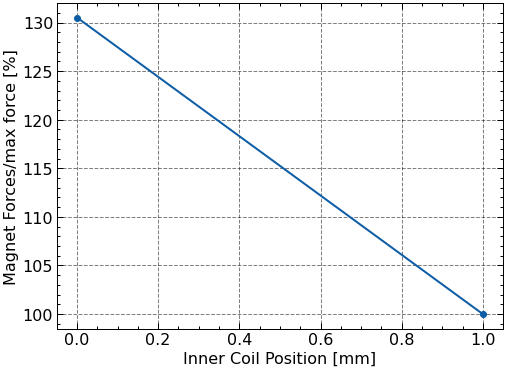

C:\Users\kumar\AppData\Local\Temp/ipykernel_29924/970137090.py:482: RuntimeWarning: divide by zero encountered in true_divide
  Norm_Magnet_Forces = modelled.Magnet_Forces/sensor.para()[2]


ValueError: array must not contain infs or NaNs

In [12]:
import design
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
import shutil

femm.openfemm()
femm.newdocument(0)

outputfile = 'small_F0_MirrorTower_1mA_32AWG_6_5_5.out'
NSteps = 1
StepSize = 1
Upp_Inncoil_Offset = 0

sensor = design.Sensortype(1, 0, 0)
femm.mi_probdef(sensor.para()[1], 'millimeters', 'axi', 1.0e-10)
wire = design.Wiretype("32 AWG", "32 AWG")
block = design.Blocks()
geo = design.Geometry1(innUP_ht = 15, innLOW_ht = 22.5, inn_rad = 13.55, inn_layers = 6, inn_dist = 45, out_ht = 12, out_rad = 20.5, out_layers = 5, out_dist = 13, mag_ht = 6.35, mag_rad = 4.47, ver_shi = 0)

class Position():
    def __init__(self):
        pass
    def upp_outcoil(self):
        UppOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        UppOutCoil_LowEnd = (geo.outcoil()[3] - geo.outcoil()[0]) / 2
        UppOutCoil_UppEnd = UppOutCoil_LowEnd + geo.outcoil()[0]
        UppOutCoil_NrWind_p_Layer = (geo.outcoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        UppOutCoil_Circuit = "UppOutCoil_Circuit"
        return [UppOutCoil_OutRadius, UppOutCoil_LowEnd, UppOutCoil_UppEnd, UppOutCoil_NrWind_p_Layer,
                UppOutCoil_NrWindings, UppOutCoil_Circuit]

    def low_outcoil(self):
        LowOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        LowOutCoil_UppEnd = -1 * ((geo.outcoil()[3] - geo.outcoil()[0]) / 2)
        LowOutCoil_LowEnd = LowOutCoil_UppEnd - geo.outcoil()[0]
        LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd - LowOutCoil_LowEnd) / (
                    wire.prop31()[0] + wire.prop31()[1] * 2)
        LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        LowOutCoil_Circuit = "LowOutCoil_Circuit"
        return [LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_LowEnd, LowOutCoil_NrWind_p_Layer,
                LowOutCoil_NrWindings, LowOutCoil_Circuit]
    
    def Upp_Inncoil(self):
        Upp_Inncoil_OutRadius = geo.Upp_Inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.Upp_Inncoil()[2])
        Upp_Inncoil_Lowend = -1*(geo.Upp_Inncoil()[0]) / 2
        Upp_Inncoil_Uppend = Upp_Inncoil_Lowend + geo.Upp_Inncoil()[0]
        Upp_Inncoil_NrWind_p_Layer = (geo.Upp_Inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        Upp_Inncoil_NrWindings = Upp_Inncoil_NrWind_p_Layer * geo.Upp_Inncoil()[2]
        Upp_Inncoil_Circuit = "Upp_Inncoil_Circuit"
        return [Upp_Inncoil_OutRadius, Upp_Inncoil_Lowend, Upp_Inncoil_Uppend, Upp_Inncoil_NrWind_p_Layer, Upp_Inncoil_NrWindings,
                Upp_Inncoil_Circuit]

    def Low_Inncoil(self):
        Low_Inncoil_OutRadius = geo.Low_Inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.Low_Inncoil()[2])
        Low_Inncoil_Lowend = -1*(geo.Low_Inncoil()[3] + (geo.Low_Inncoil()[0])/2)
        Low_Inncoil_Uppend = Low_Inncoil_Lowend + geo.Low_Inncoil()[0]
        Low_Inncoil_NrWind_p_Layer = (geo.Upp_Inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        Low_Inncoil_NrWindings = Low_Inncoil_NrWind_p_Layer * geo.Upp_Inncoil()[2]
        Low_Inncoil_Circuit = "Low_Inncoil_Circuit"
        return [Low_Inncoil_OutRadius, Low_Inncoil_Lowend, Low_Inncoil_Uppend, Low_Inncoil_NrWind_p_Layer, Low_Inncoil_NrWindings,
                Low_Inncoil_Circuit]
position = Position()

class Yoke():
    def __init__(self):
        pass
    def block1(self):
        b1_lowend = -1*(geo.Low_Inncoil()[3] + (block.b3()[1])/2 + block.b4()[1] + geo.mag()[0] + block.b6()[1])
        b1_uppend = b1_lowend + block.b1()[1]
        b1_innrad = block.yokeinnrad
        b1_outrad = b1_innrad + block.b1()[0]
        return [b1_innrad, b1_uppend, b1_outrad, b1_lowend]
    def block2(self):
        b2_innrad = block.yokeinnrad + block.b1_l
        b2_uppend = block.yokeuppend
        b2_lowend = b2_uppend - block.b2_h
        b2_outrad = b2_innrad + block.b2_l
        return [b2_innrad, b2_uppend, b2_outrad, b2_lowend]
    def block3(self):
        b3_innrad = geo.Low_Inncoil()[1] + 2.45
        b3_outrad = b3_innrad + block.b3_l
        b3_uppend = block.yokeuppend
        b3_lowend = b3_uppend - block.b3_h
        return [b3_innrad, b3_uppend, b3_outrad, b3_lowend]
    def block4(self):
        b4_innrad = geo.Low_Inncoil()[1] + 8.5
        b4_uppend = block.yokeuppend - block.b3_h
        b4_outrad = b4_innrad + block.b4_l
        b4_lowend = b4_uppend - block.b4_h
        return [b4_innrad, b4_uppend, b4_outrad, b4_lowend]
    def block5(self):
        b5_innrad = geo.Low_Inncoil()[1] + 8.5
        b5_uppend = block.yokeuppend - block.b3_h - block.b4_h
        b5_outrad = b5_innrad + block.b5_l
        b5_lowend = b5_uppend - block.b5_h
        return [b5_innrad, b5_uppend, b5_outrad, b5_lowend]
    def mag(self):
        mag_innrad = block.yokeoutrad - geo.mag()[1]
        mag_outrad = mag_innrad + geo.mag()[1]
        mag_uppend = block.yokeuppend - block.b3_h - block.b4_h
        mag_lowend = mag_uppend - geo.mag()[0]
        return [mag_innrad, mag_uppend, mag_outrad, mag_lowend]
    def block6(self):
        b6_innrad = block.yokeoutrad - geo.mag()[1]
        b6_outrad = b6_innrad + block.b6_l
        b6_uppend = block.yokeuppend - block.b3_h - block.b4_h - geo.mag()[0]
        b6_lowend = b6_uppend - block.b6_h
        return [b6_innrad, b6_uppend, b6_outrad, b6_lowend]
    def block7(self):
        b7_innrad = block.yokeinnrad + 3.25
        b7_outrad = b7_innrad + block.b7_l
        b7_lowend = block.yokeuppend - block.b3_h - block.b4_h - geo.mag()[0] - block.b6_h
        b7_uppend = b7_lowend + block.b7_h
        return [b7_innrad, b7_uppend, b7_outrad, b7_lowend]
yoke = Yoke()

class Length():
    def __init__(self):
        pass
    
    def upp_outcoil(self):
        UppOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):

            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            UppOutCoil_TotalWire += circ * position.upp_outcoil()[3]
        print("Total length of wire (mm):", UppOutCoil_TotalWire)
        print("\n")
        return UppOutCoil_TotalWire
    def low_outcoil(self):
        LowOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):

            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            LowOutCoil_TotalWire += circ * position.low_outcoil()[3]
        print("Total length of wire (mm):", LowOutCoil_TotalWire)
        print("\n")
        return LowOutCoil_TotalWire
    def Low_Inncoil(self):
        Low_Inncoil_TotalWire = 0
        for i in range(0, geo.Low_Inncoil()[2]):

            circ = 2 * np.pi * (geo.Low_Inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            Low_Inncoil_TotalWire += circ * position.Low_Inncoil()[3]
        print("Total length of wire (mm):", Low_Inncoil_TotalWire)
        print("\n")
        return Low_Inncoil_TotalWire
    def Upp_Inncoil(self):
        Upp_Inncoil_TotalWire = 0
        for i in range(0, geo.Upp_Inncoil()[2]):

            circ = 2 * np.pi * (geo.Upp_Inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            Upp_Inncoil_TotalWire += circ * position.Low_Inncoil()[3]
        print("Total length of wire (mm):", Upp_Inncoil_TotalWire)
        print("\n")
        return Upp_Inncoil_TotalWire
length = Length()

class Modelling():
    def __init__(self):
        pass
    # UpperOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                          position.upp_outcoil()[1])
    femm.mi_addcircprop(position.upp_outcoil()[5], sensor.para()[2], 1)

    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.outcoil_material)

    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                            position.upp_outcoil()[1], 4)
    femm.mi_setgroup(1)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop32()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop32()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop32()[2], 0, 0.1, position.upp_outcoil()[5], 0, 1, position.upp_outcoil()[4])
    femm.mi_clearselected()
    
    # LowerOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                          position.low_outcoil()[2])
    femm.mi_addcircprop(position.low_outcoil()[5], -sensor.para()[2], 1)
    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.outcoil_material)
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                            position.low_outcoil()[2], 4)
    femm.mi_setgroup(2)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop32()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop32()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop32()[2], 0, 0.1, position.low_outcoil()[5], 0, 2, position.low_outcoil()[4])
    femm.mi_clearselected()
    
    # LowInnerCoil Structure
    femm.mi_drawrectangle(geo.Low_Inncoil()[1], position.Low_Inncoil()[2], position.Low_Inncoil()[0], position.Low_Inncoil()[1])
    femm.mi_addcircprop(position.Low_Inncoil()[5], sensor.para()[0], 1)
    if wire.inncoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.inncoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.Low_Inncoil()[1], position.Low_Inncoil()[2], position.Low_Inncoil()[0], position.Low_Inncoil()[1], 4)
    femm.mi_setgroup(3)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.Low_Inncoil()[1] + wire.prop32()[1], position.Low_Inncoil()[1] + (geo.Low_Inncoil()[0] / 2))
    femm.mi_selectlabel(geo.Low_Inncoil()[1] + wire.prop32()[1], position.Low_Inncoil()[1] + (geo.Low_Inncoil()[0] / 2))
    femm.mi_setblockprop(wire.prop32()[2], 1, 0, position.Low_Inncoil()[5], 0, 3, position.Low_Inncoil()[4])
    femm.mi_clearselected()

    # UppInnerCoil Structure
    femm.mi_drawrectangle(geo.Upp_Inncoil()[1], position.Upp_Inncoil()[2], position.Upp_Inncoil()[0], position.Upp_Inncoil()[1])
    femm.mi_addcircprop(position.Upp_Inncoil()[5], sensor.para()[2], 1)
    if wire.inncoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.inncoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.Upp_Inncoil()[1], position.Upp_Inncoil()[2], position.Upp_Inncoil()[0], position.Upp_Inncoil()[1], 4)
    femm.mi_setgroup(4)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.Upp_Inncoil()[1] + wire.prop32()[1], position.Upp_Inncoil()[1] + (geo.Upp_Inncoil()[0] / 2))
    femm.mi_selectlabel(geo.Upp_Inncoil()[1] + wire.prop32()[1], position.Upp_Inncoil()[1] + (geo.Upp_Inncoil()[0] / 2))
    femm.mi_setblockprop(wire.prop32()[2], 1, 0, position.Upp_Inncoil()[5], 0, 4, position.Upp_Inncoil()[4])
    femm.mi_clearselected()

    # magnet Structure
    femm.mi_drawrectangle(yoke.mag()[0], yoke.mag()[1], yoke.mag()[2], yoke.mag()[3])
    femm.mi_getmaterial(wire.mag_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.mag()[0], yoke.mag()[1], yoke.mag()[2], yoke.mag()[3], 4)
    femm.mi_setgroup(5)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.mag()[0] + (geo.mag()[1] * 0.5), yoke.mag()[3] + (geo.mag()[0] * 0.5))
    femm.mi_selectlabel(yoke.mag()[0] + (geo.mag()[1] * 0.5), yoke.mag()[3] + (geo.mag()[0] * 0.5))
    femm.mi_setblockprop(wire.mag_mat(), 0, 0.1, "", 90, 5, 0)
    femm.mi_clearselected()

    #block1
    femm.mi_drawrectangle(yoke.block1()[0], yoke.block1()[1], yoke.block1()[2], yoke.block1()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block1()[0], yoke.block1()[1], yoke.block1()[2], yoke.block1()[3], 4)
    femm.mi_setgroup(6)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block1()[0] + (block.b1_l * 0.5), yoke.block1()[3] + (block.b1_h * 0.5))
    femm.mi_selectlabel(yoke.block1()[0] + (block.b1_l * 0.5), yoke.block1()[3] + (block.b1_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 6, 0)
    femm.mi_clearselected()

    #block2
    femm.mi_drawrectangle(yoke.block2()[0], yoke.block2()[1], yoke.block2()[2], yoke.block2()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block2()[0], yoke.block2()[1], yoke.block2()[2], yoke.block2()[3], 4)
    femm.mi_setgroup(7)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block2()[0] + (block.b2_l * 0.5), yoke.block2()[3] + (block.b2_h * 0.5))
    femm.mi_selectlabel(yoke.block2()[0] + (block.b2_l * 0.5), yoke.block2()[3] + (block.b2_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 7, 0)
    femm.mi_clearselected()

    #block3
    femm.mi_drawrectangle(yoke.block3()[0], yoke.block3()[1], yoke.block3()[2], yoke.block3()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block3()[0], yoke.block3()[1], yoke.block3()[2], yoke.block3()[3], 4)
    femm.mi_setgroup(8)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block3()[0] + (block.b3_l * 0.5), yoke.block3()[3] + (block.b3_h * 0.5))
    femm.mi_selectlabel(yoke.block3()[0] + (block.b3_l * 0.5), yoke.block3()[3] + (block.b3_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 8, 0)
    femm.mi_clearselected()

    #block4
    femm.mi_drawrectangle(yoke.block4()[0], yoke.block4()[1], yoke.block4()[2], yoke.block4()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block4()[0], yoke.block4()[1], yoke.block4()[2], yoke.block4()[3], 4)
    femm.mi_setgroup(9)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block4()[0] + (block.b4_l * 0.5), yoke.block4()[3] + (block.b4_h * 0.5))
    femm.mi_selectlabel(yoke.block4()[0] + (block.b4_l * 0.5), yoke.block4()[3] + (block.b4_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 9, 0)
    femm.mi_clearselected()

    #block5
    femm.mi_drawrectangle(yoke.block5()[0], yoke.block5()[1], yoke.block5()[2], yoke.block5()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block5()[0], yoke.block5()[1], yoke.block5()[2], yoke.block5()[3], 4)
    femm.mi_setgroup(10)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block5()[0] + (block.b5_l * 0.5), yoke.block5()[3] + (block.b5_h * 0.5))
    femm.mi_selectlabel(yoke.block5()[0] + (block.b5_l * 0.5), yoke.block5()[3] + (block.b5_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 10, 0)
    femm.mi_clearselected()

    #block6
    femm.mi_drawrectangle(yoke.block6()[0], yoke.block6()[1], yoke.block6()[2], yoke.block6()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block6()[0], yoke.block6()[1], yoke.block6()[2], yoke.block6()[3], 4)
    femm.mi_setgroup(11)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block6()[0] + (block.b6_l * 0.5), yoke.block6()[3] + (block.b6_h * 0.5))
    femm.mi_selectlabel(yoke.block6()[0] + (block.b6_l * 0.5), yoke.block6()[3] + (block.b6_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 11, 0)
    femm.mi_clearselected()

    #block7
    femm.mi_drawrectangle(yoke.block7()[0], yoke.block7()[1], yoke.block7()[2], yoke.block7()[3])
    femm.mi_getmaterial(wire.yoke_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(yoke.block7()[0], yoke.block7()[1], yoke.block7()[2], yoke.block7()[3], 4)
    femm.mi_setgroup(12)
    femm.mi_clearselected()
    femm.mi_addblocklabel(yoke.block7()[0] + (block.b7_l * 0.5), yoke.block7()[3] + (block.b7_h * 0.5))
    femm.mi_selectlabel(yoke.block7()[0] + (block.b7_l * 0.5), yoke.block7()[3] + (block.b7_h * 0.5))
    femm.mi_setblockprop(wire.yoke_mat(), 0, 0.1, "", 0, 12, 0)
    femm.mi_clearselected()

    # AirSurrounding Structure
    AirSpaceRadius_1 = 100
    AirSpaceRadius_2 = 300
    BC_Name = "Outside"
    BC_Group = 10
    # Airspace1
    femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
    femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_selectlabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
    femm.mi_clearselected()
    # Airspace2
    femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
    femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_selectlabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
    femm.mi_clearselected()
    # Boundary properties
    femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    femm.mi_clearselected()
    femm.mi_selectarcsegment(0, AirSpaceRadius_2)
    femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
    femm.mi_clearselected()

    UppOutCoil_Forces = np.zeros(NSteps+1)
    LowOutCoil_Forces = np.zeros(NSteps+1)
    Magnet_Forces = np.zeros(NSteps+1)
    InnCoil_Positions = np.zeros(NSteps+1)
    MetaData = np.zeros(NSteps+1)

    femm.mi_selectgroup(3)
    femm.mi_selectgroup(4)
    femm.mi_movetranslate(0, Upp_Inncoil_Offset)
    femm.mi_clearselected()
modelled = Modelling()

class Computation_loop():
    def __init__(self):
        pass
    for i in range(0, NSteps + 1):

        print(Upp_Inncoil_Offset + StepSize * i)
        modelled.InnCoil_Positions[i] = Upp_Inncoil_Offset + (StepSize * i)

        femm.mi_zoom(-2, -50, 50, 50)
        femm.mi_refreshview()
        femm.mi_saveas('Mirror_tower position_ETpf_LIP.fem')
        femm.mi_analyze()
        femm.mi_loadsolution()

        if NSteps == 0:

            femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
            femm.mo_zoom(-2, -50, 50, 50)
            femm.mo_refreshview()

        femm.mo_groupselectblock(1)
        UppOut_Force19 = femm.mo_blockintegral(19)
        femm.mo_clearblock()

        femm.mo_groupselectblock(2)
        LowOut_Force19 = femm.mo_blockintegral(19)
        femm.mo_clearblock()

        femm.mo_groupselectblock(5)
        Magn_Force19 = femm.mo_blockintegral(19)
        femm.mo_clearblock()

        print("Upper Outer Coil force = ",UppOut_Force19, "Lower Outer Coil force = ", LowOut_Force19, "Magnet force = ", Magn_Force19)
        modelled.UppOutCoil_Forces[i] = UppOut_Force19
        modelled.LowOutCoil_Forces[i] = LowOut_Force19
        modelled.Magnet_Forces[i] = Magn_Force19
       # Translate inner coil to different distance
        femm.mi_selectgroup(4)
        femm.mi_selectgroup(3)
        femm.mi_movetranslate(0, StepSize)
        femm.mi_clearselected()
loop = Computation_loop()
print(modelled.InnCoil_Positions)
print(modelled.UppOutCoil_Forces)
print(modelled.LowOutCoil_Forces)
print(modelled.Magnet_Forces)
if NSteps > 2:
   modelled.MetaData[0] = NSteps
   modelled.MetaData[1] = StepSize
   modelled.MetaData[2] = sensor.para()[2]
   np.savetxt(outputfile, (modelled.InnCoil_Positions, modelled.UppOutCoil_Forces, modelled.LowOutCoil_Forces, modelled.Magnet_Forces, modelled.MetaData))

class Results():
    def __init__(self):
        pass
    plt.style.use(['science','grid','notebook'])

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Forces, 'o-')
    plt.ylabel('Lower Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("low for.png")
    #shutil.move("low for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.UppOutCoil_Forces, 'o-')
    plt.ylabel('Upper Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("upp for.png")
    #shutil.move("upp for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces, 'o-')
    plt.ylabel('Magnet Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("mf.png")
    #shutil.move("mf.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Forces + modelled.UppOutCoil_Forces,'o-')
    plt.ylabel('Sum of Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("outsum.png")
    #shutil.move("outsum.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces - abs(modelled.LowOutCoil_Forces + modelled.UppOutCoil_Forces),'o-')
    plt.ylabel('Force on Magnet - Force on Outer Coils [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("mf - inn for.png")
    #shutil.move("mf - inn for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces/max(modelled.Magnet_Forces)*100, 'o-')
    plt.ylabel('Magnet Forces/max force [%]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("nmf.png")
    #shutil.move("nmf.png", r"<path>")
    plt.show()

    def polyfunc(x, a, b, c):
        return a*x**2 + b*x + c

    Norm_Magnet_Forces = modelled.Magnet_Forces/sensor.para()[2]
    optimizedParameters, pcov = opt.curve_fit(polyfunc, modelled.InnCoil_Positions, Norm_Magnet_Forces)
    print("Fitted parameters of function:", optimizedParameters)
    fitted_Norm_Magnet_Forces = polyfunc(modelled.InnCoil_Positions, *optimizedParameters)
    print(Norm_Magnet_Forces)

    plt.plot(modelled.InnCoil_Positions, Norm_Magnet_Forces, label="simulation")
    plt.plot(modelled.InnCoil_Positions, fitted_Norm_Magnet_Forces, '--', label="poly2 fit")
    plt.ylabel('Normalised Magnet Force [N/A]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend()
    #plt.savefig("fit for.png")
    #shutil.move("fit for.png", r"<path>")
    plt.show()

    print(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
    plt.plot(modelled.InnCoil_Positions, Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
    plt.ylabel('Fit error [N/A]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("fit err.png")
    #shutil.move("fit err.png", r"<path>")
    plt.show()

    print((abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces))*100)
    plt.plot(modelled.InnCoil_Positions, abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces)*100)
    plt.ylabel('Normalised Fit error [%]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("norfit.png")
    #shutil.move("norfit.png", r"<path>")
    #plt.ylim(0.0,0.01)
    plt.show()
results = Results()

7


In [ ]:
if NSteps > 2:
   modelled.MetaData[0] = NSteps
   modelled.MetaData[1] = StepSize
   modelled.MetaData[2] = sensor.para()[2]
   np.savetxt(outputfile, (modelled.InnCoil_Positions, modelled.UppOutCoil_Forces, modelled.LowOutCoil_Forces, modelled.Magnet_Forces, modelled.MetaData))

class Results():
    def __init__(self):
        pass
    plt.style.use(['science','grid','notebook'])

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Forces, 'o-')
    plt.ylabel('Lower Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("low for.png")
    #shutil.move("low for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.UppOutCoil_Forces, 'o-')
    plt.ylabel('Upper Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("upp for.png")
    #shutil.move("upp for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces, 'o-')
    plt.ylabel('Magnet Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("mf.png")
    #shutil.move("mf.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Forces + modelled.UppOutCoil_Forces,'o-')
    plt.ylabel('Sum of Outer Coil Force [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("outsum.png")
    #shutil.move("outsum.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces - abs(modelled.LowOutCoil_Forces + modelled.UppOutCoil_Forces),'o-')
    plt.ylabel('Force on Magnet - Force on Outer Coils [N]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("mf - inn for.png")
    #shutil.move("mf - inn for.png", r"<path>")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.Magnet_Forces/max(modelled.Magnet_Forces)*100, 'o-')
    plt.ylabel('Magnet Forces/max force [%]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("nmf.png")
    #shutil.move("nmf.png", r"<path>")
    plt.show()

    def polyfunc(x, a, b, c):
        return a*x**2 + b*x + c

    Norm_Magnet_Forces = modelled.Magnet_Forces/sensor.para()[2]
    optimizedParameters, pcov = opt.curve_fit(polyfunc, modelled.InnCoil_Positions, Norm_Magnet_Forces)
    print("Fitted parameters of function:", optimizedParameters)
    fitted_Norm_Magnet_Forces = polyfunc(modelled.InnCoil_Positions, *optimizedParameters)
    print(Norm_Magnet_Forces)

    plt.plot(modelled.InnCoil_Positions, Norm_Magnet_Forces, label="simulation")
    plt.plot(modelled.InnCoil_Positions, fitted_Norm_Magnet_Forces, '--', label="poly2 fit")
    plt.ylabel('Normalised Magnet Force [N/A]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend()
    #plt.savefig("fit for.png")
    #shutil.move("fit for.png", r"<path>")
    plt.show()

    print(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
    plt.plot(modelled.InnCoil_Positions, Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
    plt.ylabel('Fit error [N/A]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("fit err.png")
    #shutil.move("fit err.png", r"<path>")
    plt.show()

    print((abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces))*100)
    plt.plot(modelled.InnCoil_Positions, abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces)*100)
    plt.ylabel('Normalised Fit error [%]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("norfit.png")
    #shutil.move("norfit.png", r"<path>")
    #plt.ylim(0.0,0.01)
    plt.show()
results = Results()